In [1]:
import pandas as pd
import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from numpy import array
from typing import List
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

from stop_words import get_stop_words
import json
import re

from wordcloud import WordCloud

articles_file = "articulos.json"
path_to_file = "../data/"
data = pd.read_json(os.path.join(path_to_file,articles_file))
data = data.sample(len(data)).reset_index(drop=True)

Exploración inicial de los datos, balanceo del conjunto de datos

In [2]:
data.head()

,articulo,categoria
0,Marc Márquez será protagonista en el Camp Nou ...,deportes
1,"Por primera vez, los investigadores han evalua...",sanidad
2,"Para averiguarlo, investigadores de la America...",sanidad
3,La legislatura se inició este martes en el Con...,politica
4,No hay duda de que la prioridad de Zidane es d...,deportes


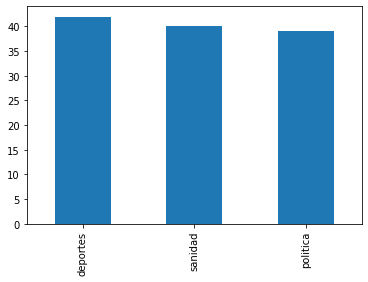

In [3]:
data.categoria.value_counts().plot(kind='bar')

Wordclouds con los terminos mas usados en las tres categorias

In [4]:
# Read the file in dictionary format
with open(os.path.join(path_to_file,articles_file), "r", encoding="utf8") as file:
    articles = json.load(file)
    
word_counts = {}
for category in data.categoria.unique():
    word_counts[category] = []

# Obtenemos los caracteres alfanumericos y evitamos las stop-words
for article in articles:
    for w in re.findall(r"[\w']+", article['articulo']):
        w = w.replace("”", "").replace("’", "").replace("%", "")
        w = w.replace(".", "").replace("\"", "").replace("“", "").replace("‘", "")
        w = w.replace("(", "").replace(")", "").replace(",", "").replace("”", "")
        w = w.replace("–", "").replace("-", "").replace("_", "").replace("'", "")
        if w.lower() not in get_stop_words("spanish") and w!= " ":
            word_counts[article['categoria']].append(w.lower())
            
for k,v in word_counts.items():
    print(f"La categoría {k} tiene {len(set(v))} palabras unicas de un total de {len(v)}" )
    


La categoría deportes tiene 2032 palabras unicas de un total de 3883
La categoría sanidad tiene 1310 palabras unicas de un total de 2027
La categoría politica tiene 1467 palabras unicas de un total de 2869


Imprimimos el top 10 terminos para cada categoria

In [5]:
for k,v in word_counts.items():
    # initializing a dictionary
    d = {}

    # counting number of times each word comes up in list of words
    for key in v: 
        d[key] = d.get(key, 0) + 1

    print(f"Top 10 terminos {k} (apariciones): ")

    for e in sorted(d.items(), key = lambda x: x[1], reverse = True)[:10]:
        print(f"    - {e[0]} ({e[1]})")
        
    for _ in range(2): print()

Top 10 terminos deportes (apariciones): 
    - 1 (35)
    - puntos (31)
    - 0 (31)
    - partido (28)
    - min (28)
    - equipo (27)
    - tras (24)
    - parte (24)
    - club (20)
    - mientras (19)


Top 10 terminos sanidad (apariciones): 
    - salud (45)
    - enfermedad (14)
    - riesgo (10)
    - cáncer (10)
    - personas (9)
    - ser (9)
    - hospital (8)
    - años (8)
    - obesidad (8)
    - forma (8)


Top 10 terminos politica (apariciones): 
    - gobierno (47)
    - congreso (33)
    - investidura (28)
    - sánchez (25)
    - psoe (20)
    - política (20)
    - españa (19)
    - catalunya (18)
    - pp (16)
    - erc (15)




Guardamos un documento por cada categoria

In [6]:
for k,v in word_counts.items():
    with open(os.path.join(path_to_file,f"{k}.txt"), "w") as t:
        for w in v:
            if w.lower() not in get_stop_words("spanish"):
                t.write(w + " ")

Imprimimos el wordcloud

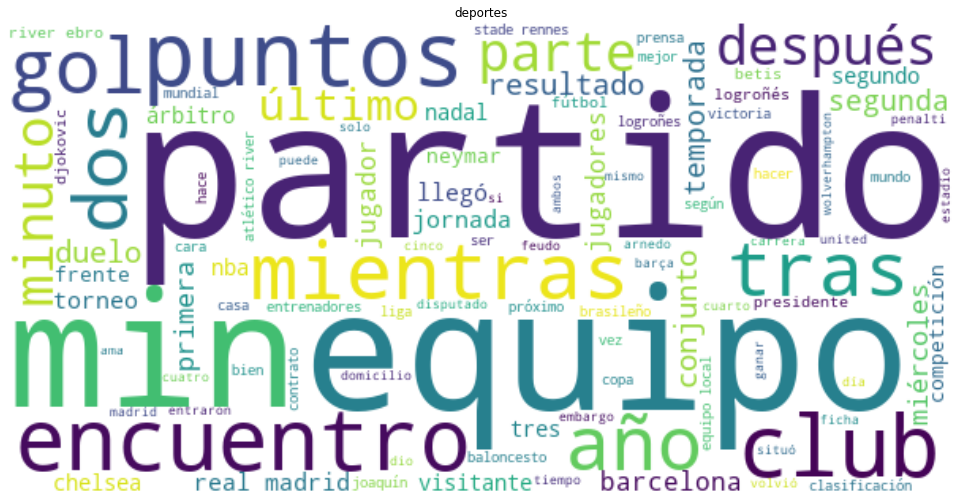

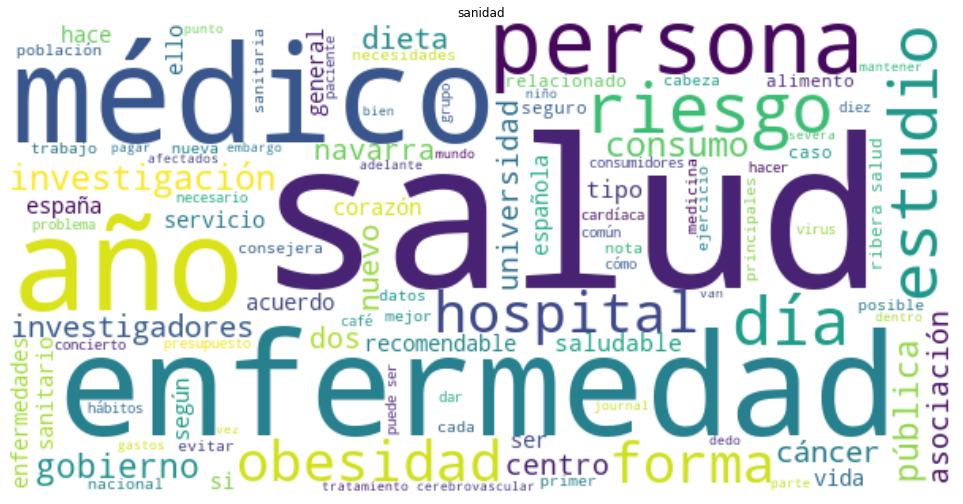

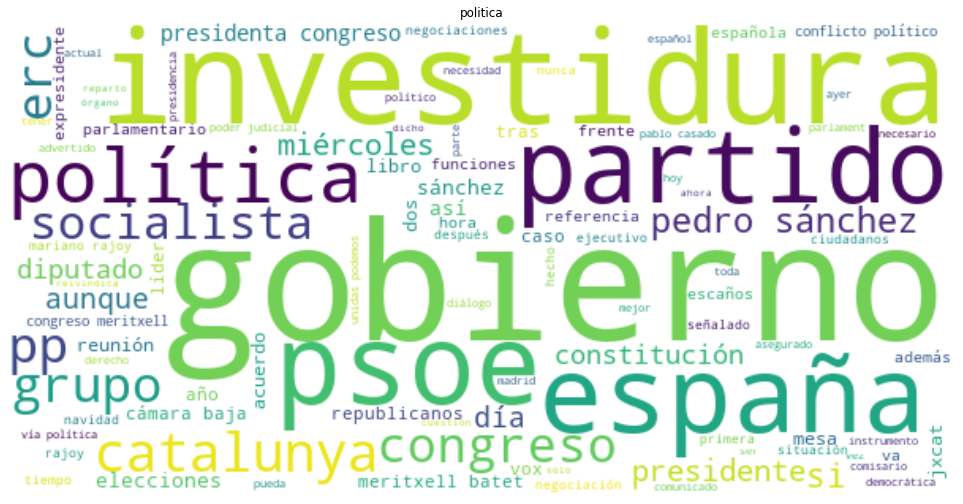

In [7]:
wclouds = {}
for k in word_counts.keys():
    text = open(os.path.join(path_to_file,f"{k}.txt")).read()
    wclouds[k] = WordCloud(background_color="white", max_words=100, width=600, height=300, random_state=1).generate(text)
    
    plt.figure(figsize=(17,11))
    plt.title(k)
    plt.imshow(wclouds[k], interpolation='bilinear')
    plt.axis("off")


Seleccionamos las top 100 palabras de cada uno de los temas y de ellas seleccionamos un conjunto disjunto

In [8]:
glosario = {}
for k in word_counts.keys():
    glosario[k] = []

for k,v in word_counts.items():
    # initializing a dictionary
    d = {}

    # counting number of times each word comes up in list of words
    for key in v: 
        d[key] = d.get(key, 0) + 1

    for e in sorted(d.items(), key = lambda x: x[1], reverse = True)[:100]:
        glosario[k].append(e[0])


Seleccionamos un conjunto disjunto de palabras para cada uno de los tres temas

In [9]:
curated_glosario = {}
curated_glosario['sanidad'] = list( set( glosario['sanidad'] ) - set( glosario['deportes'] + glosario['politica'] ) )
curated_glosario['deportes'] = list( set( glosario['deportes'] ) - set( glosario['sanidad'] + glosario['politica'] ) )
curated_glosario['politica'] = list( set( glosario['politica'] ) - set( glosario['deportes'] + glosario['sanidad'] ) )

for k,v in curated_glosario.items():
    print(f"La categoria {k} tiene un glosario de {len(v)} terminos disjuntos")

La categoria sanidad tiene un glosario de 82 terminos disjuntos
La categoria deportes tiene un glosario de 82 terminos disjuntos
La categoria politica tiene un glosario de 78 terminos disjuntos


In [10]:
# Terminos por cada glosario
for k,v in curated_glosario.items():
    print(f"{k}: {v}")
    print()

sanidad: ['cada', 'punto', 'cáncer', 'pagar', 'obesidad', 'enfermedad', 'universidad', 'mundo', 'diez', 'cerebrovascular', 'vida', 'seguro', 'cómo', 'necesidades', 'común', 'forma', 'gastos', 'consejera', 'sanitario', 'puede', 'medicina', 'hábitos', 'dentro', 'estudio', 'población', 'café', 'investigadores', 'mantener', 'base', 'dar', 'embargo', 'profesionales', 'año', 'nueva', 'ribera', 'arrendamiento', 'afectados', '40', 'alimentos', 'revista', 'principales', 'virus', 'primer', 'sueño', 'nota', 'asociación', 'evitar', 'consumo', '000', 'nuevo', 'dieta', 'van', 'hospital', 'médico', 'of', 'tratamiento', 'the', 'necesario', 'riesgo', 'corazón', 'investigación', 'consumidores', '20', 'enfermedades', 'recomendable', 'navarra', 'tan', 'médicos', 'servicio', 'journal', 'sanitaria', 'ello', 'centro', 'datos', 'días', 'saludable', 'tipo', 'pública', '18', 'salud', 'adelante', 'personas']

deportes: ['joaquín', '1', 'jugador', 'local', 'casa', 'mientras', 'entrenadores', 'minuto', 'baloncesto

In [11]:
# Eliminamos los terminos para cada uno de los glosarios
to_remove_politica = ['hora', 'hoy', 'así', 'josé', 'hecho', 'navidad',
                      'va', 'ayer', 'tiempo', 'además', 'aunque']
to_remove_deportes = ['ham', 'mientras', 'prensa', 'logroñés', 'logroñes', 'mario', 'miguel', 'ebro']
to_remove_sanidad = ['000', '20', '18', 'of', 'the', 'embargo', 'puede', 'cómo', 'dar']

for elem in to_remove_politica: 
    curated_glosario['politica'].remove(elem)

for elem in to_remove_deportes: 
    curated_glosario['deportes'].remove(elem)
    
for elem in to_remove_sanidad: 
    curated_glosario['sanidad'].remove(elem)

# Añadimos terminos seleccionados al glosario de cada tema
to_add_politica = ['presidente', 'vicepresidente', 'oposición', 'replica', 'discusión', 'pactos', 
                   'pacto', 'arrimadas', 'junqueras', 'derecha', 'izquierda']
to_add_deportes = ['tenis', 'motor', 'márquez','messi', 'ronaldo', 'ganó', 'perdió', 'empate']
to_add_sanidad = ['resfriado', 'ambulatorio', 'intervención', 'enfermería', 'enfermero',
                  'enfermera', 'insuficiencia', 'operación', 'quirófano']

for elem in to_add_politica: 
    curated_glosario['politica'].append(elem)

for elem in to_add_deportes: 
    curated_glosario['deportes'].append(elem)
    
for elem in to_add_sanidad: 
    curated_glosario['sanidad'].append(elem)
    

# Terminos finales por cada glosario
for k,v in curated_glosario.items():
    print(f"{k}: {v}")
    print()



sanidad: ['cada', 'punto', 'cáncer', 'pagar', 'obesidad', 'enfermedad', 'universidad', 'mundo', 'diez', 'cerebrovascular', 'vida', 'seguro', 'necesidades', 'común', 'forma', 'gastos', 'consejera', 'sanitario', 'medicina', 'hábitos', 'dentro', 'estudio', 'población', 'café', 'investigadores', 'mantener', 'base', 'profesionales', 'año', 'nueva', 'ribera', 'arrendamiento', 'afectados', '40', 'alimentos', 'revista', 'principales', 'virus', 'primer', 'sueño', 'nota', 'asociación', 'evitar', 'consumo', 'nuevo', 'dieta', 'van', 'hospital', 'médico', 'tratamiento', 'necesario', 'riesgo', 'corazón', 'investigación', 'consumidores', 'enfermedades', 'recomendable', 'navarra', 'tan', 'médicos', 'servicio', 'journal', 'sanitaria', 'ello', 'centro', 'datos', 'días', 'saludable', 'tipo', 'pública', 'salud', 'adelante', 'personas', 'resfriado', 'ambulatorio', 'intervención', 'enfermería', 'enfermero', 'enfermera', 'insuficiencia', 'operación', 'quirófano']

deportes: ['joaquín', '1', 'jugador', 'local

In [12]:
def get_curated_article(art):
    res = []
    for w in re.findall(r"[\w']+", art):
        w = w.replace("”", "").replace("’", "").replace("%", "")
        w = w.replace(".", "").replace("\"", "").replace("“", "").replace("‘", "")
        w = w.replace("(", "").replace(")", "").replace(",", "").replace("”", "")
        w = w.replace("–", "").replace("-", "").replace("_", "").replace("'", "")
        if w.lower() not in get_stop_words("spanish") and w!= " ":
            res.append(w)
    
    return " ".join(res)


def get_curated_article_glossary(art, glossary):
    res = []
    for w in re.findall(r"[\w']+", art):
        w = w.replace("”", "").replace("’", "").replace("%", "")
        w = w.replace(".", "").replace("\"", "").replace("“", "").replace("‘", "")
        w = w.replace("(", "").replace(")", "").replace(",", "").replace("”", "")
        w = w.replace("–", "").replace("-", "").replace("_", "").replace("'", "")
        if w.lower() not in get_stop_words("spanish") and w!= " " and w.lower() in glossary:
            res.append(w)
            
    return " ".join(res)


glosario_final = []
for v in curated_glosario.values():
    for w in v:
        glosario_final.append(w)

In [13]:
def evaluate_logistic(data_train: pd.DataFrame, 
                      glossary: array,
                      cv = False):
    
    vectorizer = TfidfVectorizer(stop_words=get_stop_words('spanish'), analyzer='word',
                                 ngram_range=(1, 1), lowercase=True)
    
    
    if glossary:
        X = data_train.articulo.apply(lambda x: get_curated_article_glossary(x, glossary)).values
    else:
        X = data_train.articulo.apply(lambda x: get_curated_article(x)).values
    
    y = data_train.categoria.values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=23)

        
    y = data_train.categoria.values
    classifier = LogisticRegression(max_iter=25, random_state=1)
    
    vectorizer.fit(X_train)
    x_train = vectorizer.transform(X_train)
    x_test = vectorizer.transform(X_test)
    
    classifier.fit(x_train, y_train)
    if cv:
        X_total = vectorizer.transform(X)
        score = np.mean(cross_val_score(classifier, X_total, y))
    else:
        score = classifier.score(x_test, y_test)
    if glossary:
        print(f"Accuracy (Logistic Regression) using curated glossary is {round(score*100, 2)}%")
    else:
        print(f"Accuracy (Logistic Regression) not using glossary is {round(score*100, 2)}%")
        
    return vectorizer, classifier
    
    

In [14]:
def evaluate_forest(data_train: pd.DataFrame, 
                      glossary: array,
                      cv = False):
    
    vectorizer = TfidfVectorizer(stop_words=get_stop_words('spanish'), analyzer='word',
                                 ngram_range=(1, 1), lowercase=True)
    
    
    if glossary:
        X = data_train.articulo.apply(lambda x: get_curated_article_glossary(x, glossary)).values
    else:
        X = data_train.articulo.apply(lambda x: get_curated_article(x)).values
    
    y = data_train.categoria.values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=23)

        
    y = data_train.categoria.values
    classifier = RandomForestClassifier(max_depth=5, random_state=1)
    
    vectorizer.fit(X_train)
    x_train = vectorizer.transform(X_train)
    x_test = vectorizer.transform(X_test)
    
    classifier.fit(x_train, y_train)
    if cv:
        X_total = vectorizer.transform(X)
        score = np.mean(cross_val_score(classifier, X_total, y))
    else:
        score = classifier.score(x_test, y_test)
    if glossary:
        print(f"Accuracy (Random Forest) using curated glossary is {round(score*100, 2)}%")
    else:
        print(f"Accuracy (Random Forest) not using glossary is {round(score*100, 2)}%")
    
    return vectorizer, classifier

    

In [15]:
def evaluate_dec_tree(data_train: pd.DataFrame, 
                      glossary: array,
                      cv = False):
    
    vectorizer = TfidfVectorizer(stop_words=get_stop_words('spanish'), analyzer='word',
                                 ngram_range=(1, 1), lowercase=True)
    
    
    if glossary:
        X = data_train.articulo.apply(lambda x: get_curated_article_glossary(x, glossary)).values
    else:
        X = data_train.articulo.apply(lambda x: get_curated_article(x)).values
    
    y = data_train.categoria.values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=23)

        
    y = data_train.categoria.values
    classifier = DecisionTreeClassifier(random_state=1)
    
    vectorizer.fit(X_train)
    x_train = vectorizer.transform(X_train)
    x_test = vectorizer.transform(X_test)
    
    classifier.fit(x_train, y_train)
    if cv:
        X_total = vectorizer.transform(X)
        score = np.mean(cross_val_score(classifier, X_total, y))
    else:
        score = classifier.score(x_test, y_test)
    if glossary:
        print(f"Accuracy (DecisionTreeClassifier) using curated glossary is {round(score*100, 2)}%")
    else:
        print(f"Accuracy (DecisionTreeClassifier) not using glossary is {round(score*100, 2)}%")

    return vectorizer, classifier



In [16]:
_ = evaluate_dec_tree(data, None)
_ = evaluate_dec_tree(data, glosario_final)
_ = evaluate_forest(data, None)
_ = evaluate_forest(data, glosario_final)
_ = evaluate_logistic(data, None)
_ = evaluate_logistic(data, glosario_final)

Accuracy (DecisionTreeClassifier) not using glossary is 92.0%
Accuracy (DecisionTreeClassifier) using curated glossary is 92.0%
Accuracy (Random Forest) not using glossary is 80.0%
Accuracy (Random Forest) using curated glossary is 96.0%
Accuracy (Logistic Regression) not using glossary is 100.0%
Accuracy (Logistic Regression) using curated glossary is 100.0%


Ahora usamos Cross Validation para asegurarnos del accuracy de los modelos

In [17]:
_ = evaluate_dec_tree(data, None, True)
_ = evaluate_dec_tree(data, glosario_final, True)
_ = evaluate_forest(data, None, True)
_ = evaluate_forest(data, glosario_final, True)
_ = evaluate_logistic(data, None, True)
_ = evaluate_logistic(data, glosario_final, True)

Accuracy (DecisionTreeClassifier) not using glossary is 96.73%
Accuracy (DecisionTreeClassifier) using curated glossary is 87.7%
Accuracy (Random Forest) not using glossary is 84.27%
Accuracy (Random Forest) using curated glossary is 90.17%
Accuracy (Logistic Regression) not using glossary is 95.87%
Accuracy (Logistic Regression) using curated glossary is 96.73%


Como podemos ver, usando regresion logistica y glosario obtenemos los mejores resultados con un 98.37% despues de usar cross validacion para validar los resultados

Nos quedamos con el mejor modelo para clasificar los articulos como pieza de texto en la carpeta de resultados

In [18]:
vectorizer, modelo = evaluate_logistic(data, glosario_final, True)

Accuracy (Logistic Regression) using curated glossary is 96.73%


Guardamos todos los articulos en su categoria

In [19]:
X = data.articulo.apply(lambda x: get_curated_article_glossary(x, glosario_final)).values
x_prod = vectorizer.transform(X)

resultados = "../data/resultados"

if not os.path.exists(resultados):
    os.makedirs(resultados)
    
acierto_final = {
    "politica":{
        "correcto": 0,
        "incorrecto": 0
    },
    "deportes":{
        "correcto": 0,
        "incorrecto": 0
    },
    "sanidad":{
        "correcto": 0,
        "incorrecto": 0
    },
}

for i,c in enumerate(modelo.predict(x_prod)):
    categoria = os.path.join(resultados, c)
    
    if c == data.categoria[i]:
        acierto_final[data.categoria[i]]['correcto'] += 1
    else:
        acierto_final[data.categoria[i]]['incorrecto'] += 1
    
    if not os.path.exists(categoria):
        os.makedirs(categoria)
    
    with open(os.path.join(categoria,f"articulo_{i}.txt"), "w") as t:
        for w in data.articulo[i]:
            t.write(w)

acierto_final

{'politica': {'correcto': 39, 'incorrecto': 0},
 'deportes': {'correcto': 42, 'incorrecto': 0},
 'sanidad': {'correcto': 40, 'incorrecto': 0}}

In [20]:
modelo.classes_

array(['deportes', 'politica', 'sanidad'], dtype=object)

In [21]:
data = pd.read_json(os.path.join(path_to_file,articles_file))
data = data.sort_values('categoria')
X = data.articulo.apply(lambda x: get_curated_article_glossary(x, glosario_final)).values
x_prob = vectorizer.transform(X)

probabilidades = pd.DataFrame(modelo.predict_proba(x_prob)).reset_index().rename(columns={'index': 'articulo',
                                                                                          0: 'deportes',
                                                                                          1: 'politica',
                                                                                          2: 'sanidad'})
probabilidades['articulo'] = probabilidades['articulo'] + 1 
pd.set_option('display.max_rows', 125)
probabilidades

,articulo,deportes,politica,sanidad
0,1,0.722171,0.131914,0.145914
1,2,0.639344,0.177258,0.183398
2,3,0.612752,0.170207,0.217041
3,4,0.599186,0.166866,0.233948
4,5,0.667834,0.152851,0.179315
5,6,0.525926,0.225232,0.248843
6,7,0.711276,0.151114,0.137610
7,8,0.714995,0.139177,0.145828
8,9,0.439945,0.264641,0.295414
9,10,0.612164,0.212917,0.174919


Matriz de confusion
[[42  0  0]
 [ 0 39  0]
 [ 0  0 40]]
Normalized confusion matrix
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


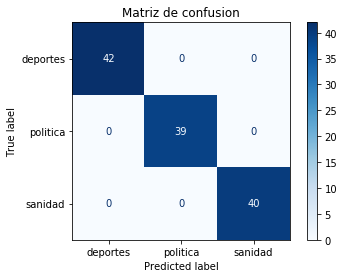

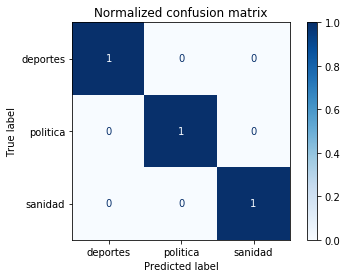

In [22]:
from sklearn.metrics import plot_confusion_matrix

# Plot non-normalized confusion matrix
titles_options = [("Matriz de confusion", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(modelo, x_prob, data.categoria.values,
                                 display_labels=modelo.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()